In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as T
from helper_functions import create_dilation_list
from modules_blocks import Network
import datetime
from load_data import img_one_hot, PrecipitationDataset, load_data_sequence_preliminary, normalize_data
from torch.utils.data import Dataset, DataLoader
import numpy as np
from helper_functions import load_zipped_pickle, save_zipped_pickle
import os
from plotting.plot_img_histogram import plot_img_histogram
import copy
# from pysteps import verification
# fss = verification.get_method("FSS")
from plot_img_histogram import plot_img_histogram

In [18]:
  #  Training data
# num_training_samples = 20  # 1000  # Number of loaded pictures (first pics not used for training but only input)
# num_validation_samples = 20  # 600

# train_start_date_time = datetime.datetime(2020, 12, 1)
# s_folder_path = '/media/jan/54093204402DAFBA/Jan/Programming/Butz_AG/weather_data/dwd_datensatz_bits/rv_recalc/RV_RECALC/hdf/'

s_sim_name = 'Run_{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

s_dirs = {}
s_dirs['save_dir'] = 'runs/{}'.format(s_sim_name)
s_dirs['plot_dir'] = '{}/plots'.format(s_dirs['save_dir'])
s_dirs['model_dir'] = '{}/model'.format(s_dirs['save_dir'])
for _, make_dir in s_dirs.items():
    if not os.path.exists(make_dir):
        os.makedirs(make_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

settings =\
    {
        's_local_machine_mode': True,

        's_sim_name': s_sim_name,
        's_folder_path': '/mnt/qb/butz/bst981/weather_data/dwd_nc/rv_recalc_months/rv_recalc_months',
        'data_file_name': 'RV_recalc_data_2019-01.nc',
        's_data_variable_name': 'RV_recalc',
        's_choose_time_span': False,
        's_time_span': (datetime.datetime(2020, 12, 1), datetime.datetime(2021, 1, 1)),
        's_ratio_training_data': 0.6,

        # Parameters that give the network architecture
        's_upscale_c_to': 512,
        's_num_bins_crossentropy': 64,

        # 'minutes_per_iteration': 5,
        's_input_height_width': 256,
        's_learning_rate': 0.0001,  # Schedule this at some point??
        's_num_epochs': 1000,
        's_num_input_time_steps': 4,
        's_optical_flow_input': False,  # Not yet working!
        's_target_height_width': 32,
        's_batch_size': 10,  # 10
        's_save_trained_model': True,
        's_load_model': False,
        's_load_model_name': 'Run_·20230220-191041',
        's_dirs': s_dirs,
        'device': device,

        # Log transform input/ validation data --> log binning --> log(x+1)
        's_log_transform': True,
        'normalize': True,
    }

if settings['s_local_machine_mode']:
    settings['s_data_variable_name'] = 'WN_forecast'
    settings['s_folder_path'] = '../dwd_nc/test_data'
    settings['data_file_name'] = 'DE1200_RV_Recalc_20190101.nc'
    settings['s_choose_time_span'] = True
    settings['s_time_span'] = (datetime.datetime(2019, 1, 1, 0), datetime.datetime(2019, 1, 1, 5))
    settings['s_upscale_c_to'] = 8
    settings['s_batch_size'] = 2

In [19]:
data_sequence = load_data_sequence_preliminary(**settings)

Loading training/validation data from ../dwd_nc/test_data/DE1200_RV_Recalc_20190101.nc


In [31]:

data_sequence_log = np.log(data_sequence+1)
data_sequence_log_norm, mean, std = normalize_data(data_sequence_log)

In [34]:
def plot_dist(data_sequence, title=''):
    plt.figure()
    data_sequence = torch.from_numpy(data_sequence)
    flat_img = torch.flatten(data_sequence)
    flat_img = flat_img.detach().cpu().numpy()
    plt.subplot(111)

    hist, bins, _ = plt.hist(flat_img, bins=8)

    plt.xlabel('log(x+1)')
    plt.yscale('log')
        plt.title(title)



IndentationError: unexpected indent (2848527041.py, line 12)

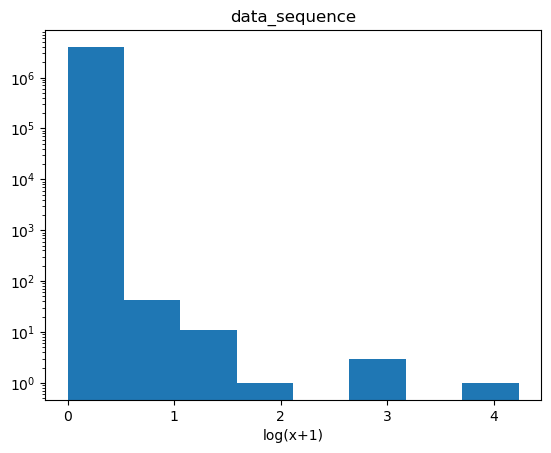

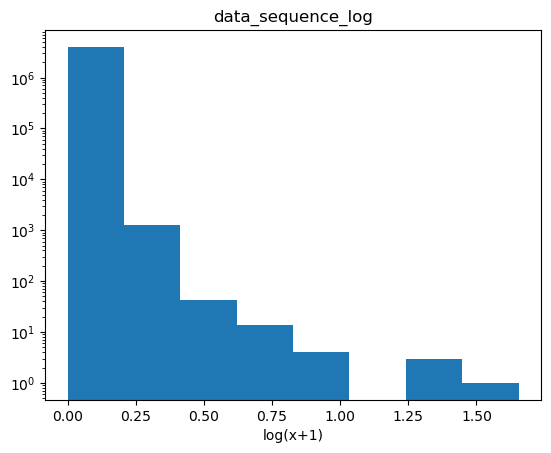

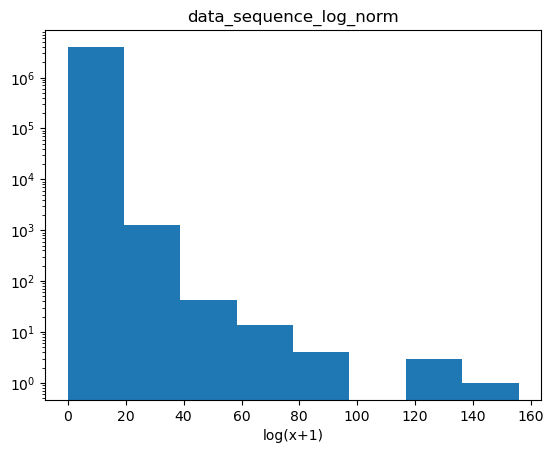

In [36]:
plot_dist(data_sequence, title='data_sequence')
plot_dist(data_sequence_log, title='data_sequence_log')
plot_dist(data_sequence_log_norm, title='data_sequence_log_norm')

In [40]:
(data_sequence == data_sequence_log).all()

False

In [43]:
(data_sequence_log == data_sequence_log_norm).all()

False

In [44]:
data_sequence_log_norm

array([[[-0.09673309, -0.09673309, -0.09673309, ..., -0.09673309,
         -0.09673309, -0.09673309],
        [-0.09673309, -0.09673309, -0.09673309, ..., -0.09673309,
         -0.09673309, -0.09673309],
        [-0.09673309, -0.09673309, -0.09673309, ..., -0.09673309,
         -0.09673309, -0.09673309],
        ...,
        [-0.09673309, -0.09673309, -0.09673309, ..., -0.09673309,
         -0.09673309, -0.09673309],
        [-0.09673309, -0.09673309, -0.09673309, ..., -0.09673309,
         -0.09673309, -0.09673309],
        [-0.09673309, -0.09673309, -0.09673309, ..., -0.09673309,
         -0.09673309, -0.09673309]],

       [[-0.09673309, -0.09673309, -0.09673309, ..., -0.09673309,
         -0.09673309, -0.09673309],
        [-0.09673309, -0.09673309, -0.09673309, ..., -0.09673309,
         -0.09673309, -0.09673309],
        [-0.09673309, -0.09673309, -0.09673309, ..., -0.09673309,
         -0.09673309, -0.09673309],
        ...,
        [-0.09673309, -0.09673309, -0.09673309, ..., -